UKDALE Appliance Parameters

In [1]:
params_appliance = {
    'kettle': {
        'windowlength': 599,
        'on_power_threshold': 2000,
        'max_on_power': 3998,
        'mean': 700,
        'std': 1000,
        's2s_length': 128,
        'houses': [1, 2],
        'channels': [10, 8],
        'train_build': [1],
        'test_build': 2,
    },
    'microwave': {
        'windowlength': 599,
        'on_power_threshold': 200,
        'max_on_power': 3969,
        'mean': 500,
        'std': 800,
        's2s_length': 128,
        'houses': [1, 2],
        'channels': [13, 15],
        'train_build': [1],
        'test_build': 2,
    },
    'fridge': {
        'windowlength': 599,
        'on_power_threshold': 50,
        'max_on_power': 3323,
        'mean': 200,
        'std': 400,
        's2s_length': 512,
        'houses': [1, 2],
        'channels': [12, 14],
        'train_build': [1],
        'test_build': 2,
    },
    

    'television': {
        'windowlength': 599,
        'on_power_threshold': 30,
        'max_on_power': 400,
        'mean': 200,
        'std': 100,
        's2s_length': 256,
        'houses': [1, 5],
        'channels': [7, 5],
        'train_build': [1],
        'test_build': 5,
    }

}


DATA_DIRECTORY = 'dataset/ukdale/'
SAVE_PATH = 'ukdale_seq2point/kettle/'
AGG_MEAN = 522
AGG_STD = 814
APPLIANCE_NAME = 'kettle'



mains_data = {
    "mean": 522,
    "std":  814        
    }

In [2]:
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import pandas as pd


def load_dataframe(directory, building, channel, col_names=['time', 'data'], nrows=None):
    df = pd.read_table(directory + 'house_' + str(building) + '/' + 'channel_' +
                       str(channel) + '.dat',
                       sep="\s+",
                       nrows=nrows,
                       usecols=[0, 1],
                       names=col_names,
                       dtype={'time': str},
                       )
    return df







class get_arguments:
    def __init__(self):
        self.data_dir = DATA_DIRECTORY
        self.appliance_name = APPLIANCE_NAME
        self.aggregate_mean = 522
        self.aggregate_std = 814
        self.save_path = SAVE_PATH
        self.batch_size = 500
        self.crop = 500000
        self.prunning_algorithm = "threshold"
        self.network_type = "seq2point"
        self.epochs = 20
        self.input_window_length = 599
        self.validation_frequency = 1


args = get_arguments()
appliance_name = args.appliance_name

Create training set

In [3]:


def main():

    start_time = time.time()
    sample_seconds = 8
    training_building_percent = 95
    validation_percent = 13
    nrows = None
    debug = False

    train = pd.DataFrame(columns=['aggregate', appliance_name])

    for h in params_appliance[appliance_name]['houses']:
        print('    ' + args.data_dir + 'house_' + str(h) + '/'
              + 'channel_' +
              str(params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses'].index(h)]) +
              '.dat')

        mains_df = load_dataframe(args.data_dir, h, 1)
        app_df = load_dataframe(args.data_dir,
                                h,
                                params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses'].index(h)],
                                col_names=['time', appliance_name]
                                )

        mains_df['time'] = pd.to_datetime(mains_df['time'], unit='s')
        mains_df.set_index('time', inplace=True)
        mains_df.columns = ['aggregate']
        #resample = mains_df.resample(str(sample_seconds) + 'S').mean()
        mains_df.reset_index(inplace=True)

        if debug:
            print("    mains_df:")
            print(mains_df.head())
            plt.plot(mains_df['time'], mains_df['aggregate'])
            plt.show()

        # Appliance
        app_df['time'] = pd.to_datetime(app_df['time'], unit='s')

        if debug:
            print("app_df:")
            print(app_df.head())
            plt.plot(app_df['time'], app_df[appliance_name])
            plt.show()

        # the timestamps of mains and appliance are not the same, we need to align them
        # 1. join the aggragte and appliance dataframes;
        # 2. interpolate the missing values;
        mains_df.set_index('time', inplace=True)
        app_df.set_index('time', inplace=True)

        df_align = mains_df.join(app_df, how='outer'). \
            resample(str(sample_seconds) + 'S').mean().fillna(method='backfill', limit=1)
        df_align = df_align.dropna()

        df_align.reset_index(inplace=True)

        del mains_df, app_df, df_align['time']

        if debug:
            # plot the dtaset
            print("df_align:")
            print(df_align.head())
            plt.plot(df_align['aggregate'].values)
            plt.plot(df_align[appliance_name].values)
            plt.show()

        # Normilization ----------------------------------------------------------------------------------------------
        mean = params_appliance[appliance_name]['mean']
        std = params_appliance[appliance_name]['std']

        df_align['aggregate'] = (df_align['aggregate'] - args.aggregate_mean) / args.aggregate_std
        df_align[appliance_name] = (df_align[appliance_name] - mean) / std

        if h == params_appliance[appliance_name]['test_build']:
            # Test CSV
            df_align.to_csv(args.save_path + appliance_name + '_test_.csv', mode='a', index=False, header=False)
            print("    Size of test set is {:.4f} M rows.".format(len(df_align) / 10 ** 6))
            continue

        
        train = pd.concat([train, df_align], ignore_index=True)
        del df_align

    # Crop dataset
    if training_building_percent != 100:
        keep =int((len(train)/100)*training_building_percent)
        train = train.head(keep)


    # Validation CSV
    val_len = int((len(train)/100)*validation_percent)
    val = train.tail(val_len)
    val.reset_index(drop=True, inplace=True)
    train.drop(train.index[-val_len:], inplace=True)
    # Validation CSV
    val.to_csv(args.save_path + appliance_name + '_validation_' + '.csv', mode='a', index=False, header=False)

    # Training CSV
    train.to_csv(args.save_path + appliance_name + '_training_.csv', mode='a', index=False, header=False)

    print("    Size of total training set is {:.4f} M rows.".format(len(train) / 10 ** 6))
    print("    Size of total validation set is {:.4f} M rows.".format(len(val) / 10 ** 6))
    del train, val


    print("\nPlease find files in: " + args.save_path)
    print("Total elapsed time: {:.2f} min.".format((time.time() - start_time) / 60))


if __name__ == '__main__':
    main()

    dataset/ukdale/house_1/channel_10.dat


C:\Users\HP\AppData\Local\Temp\ipykernel_4900\340708044.py:25: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  mains_df['time'] = pd.to_datetime(mains_df['time'], unit='s')
C:\Users\HP\AppData\Local\Temp\ipykernel_4900\340708044.py:38: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  app_df['time'] = pd.to_datetime(app_df['time'], unit='s')
C:\Users\HP\AppData\Local\Temp\ipykernel_4900\340708044.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 

    dataset/ukdale/house_2/channel_8.dat


C:\Users\HP\AppData\Local\Temp\ipykernel_4900\340708044.py:25: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  mains_df['time'] = pd.to_datetime(mains_df['time'], unit='s')
C:\Users\HP\AppData\Local\Temp\ipykernel_4900\340708044.py:38: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  app_df['time'] = pd.to_datetime(app_df['time'], unit='s')
C:\Users\HP\AppData\Local\Temp\ipykernel_4900\340708044.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 

    Size of test set is 1.6074 M rows.
    Size of total training set is 13.5306 M rows.
    Size of total validation set is 2.0218 M rows.

Please find files in: ukdale_seq2point/kettle/
Total elapsed time: 15.51 min.


Create Testset

In [4]:
nrows = 10**5
path = DATA_DIRECTORY 
save_path = SAVE_PATH
aggregate_std = AGG_STD 
aggregate_mean = AGG_MEAN

start_time = time.time()


def load(path, building, appliance, channel, nrows=None):
    # load csv
    file_name = path + 'house_' + str(building) + '/' + 'channel_' + str(channel) + '.dat'
    single_csv = pd.read_csv(file_name,
                             sep=' ',
                             #header=0,
                             names=['time', appliance],
                             dtype={'time': str, "appliance": int},
                             #parse_dates=['time'],
                             #date_parser=pd.to_datetime,
                             nrows=nrows,
                             usecols=[0, 1],
                             engine='python'
                             )
    return single_csv



print("Starting creating testset...")

for h in params_appliance[appliance_name]['houses']:

    print(path + 'house_' + str(h) + '/'
          + 'channel_' +
          str(params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses'].index(h)]) +
          '.dat')

    agg_df = load(path,
                  h,
                  appliance_name,
                  1,
                  nrows=nrows,
                  )

    df = load(path,
              h,
              appliance_name,
              params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses'].index(h)],
              nrows=nrows,
              )

    #for i in range(100):
    #    print(int(df['time'][i]) - int(agg_df['time'][i]))

    # Time conversion
    print(df.head())
    print(agg_df.head())
    df['time'] = pd.to_datetime(df['time'], unit='s')
    agg_df['time'] = pd.to_datetime(agg_df['time'], unit='s')
    print(agg_df.head())
    print(df.head())

    df['aggregate'] = agg_df[appliance_name]
    cols = df.columns.tolist()
    del cols[0]
    cols = cols[-1:] + cols[:-1]
    df = df[cols]

    print(df.head())


    # Re-sampling
    ind = pd.date_range(0,  periods=df.shape[0], freq='6S')
    df.set_index(ind, inplace=True, drop=True)
    resample = df.resample('8S')
    df = resample.mean()

    print(df.head())

    # Normalization
    df['aggregate'] = (df['aggregate'] - aggregate_mean) / aggregate_std
    df[appliance_name] = \
        (df[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name]['std']

    # Save
    df.to_csv(save_path + appliance_name + '_test_' + 'uk-dale_' + 'H' + str(h) + '.csv', index=False)

    print("Size of test set is {:.3f} M rows (House {:d})."
          .format(df.shape[0] / 10 ** 6, h))

    del df


print("\nNormalization parameters: ")
print("Mean and standard deviation values USED for AGGREGATE are:")
print("    Mean = {:d}, STD = {:d}".format(aggregate_mean, aggregate_std))

print('Mean and standard deviation values USED for ' + appliance_name + ' are:')
print("    Mean = {:d}, STD = {:d}"
      .format(params_appliance[appliance_name]['mean'], params_appliance[appliance_name]['std']))

print("\nPlease find files in: " + save_path)
tot = int(int(time.time() - start_time) / 60)
print("\nTotal elapsed time: " + str(tot) + ' min')





Starting creating testset...
dataset/ukdale/house_1/channel_10.dat
         time  kettle
0  1352500098       1
1  1352500104       1
2  1352500110       1
3  1352500116       1
4  1352500122       1
         time  kettle
0  1352500095     599
1  1352500101     582
2  1352500107     600
3  1352500113     586
4  1352500120     596


C:\Users\HP\AppData\Local\Temp\ipykernel_7728\2486482736.py:57: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time'] = pd.to_datetime(df['time'], unit='s')
C:\Users\HP\AppData\Local\Temp\ipykernel_7728\2486482736.py:58: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  agg_df['time'] = pd.to_datetime(agg_df['time'], unit='s')


                 time  kettle
0 2012-11-09 22:28:15     599
1 2012-11-09 22:28:21     582
2 2012-11-09 22:28:27     600
3 2012-11-09 22:28:33     586
4 2012-11-09 22:28:40     596
                 time  kettle
0 2012-11-09 22:28:18       1
1 2012-11-09 22:28:24       1
2 2012-11-09 22:28:30       1
3 2012-11-09 22:28:36       1
4 2012-11-09 22:28:42       1
   aggregate  kettle
0        599       1
1        582       1
2        600       1
3        586       1
4        596       1
                     aggregate  kettle
1970-01-01 00:00:00      590.5     1.0
1970-01-01 00:00:08      600.0     1.0
1970-01-01 00:00:16      586.0     1.0
1970-01-01 00:00:24      588.5     1.0
1970-01-01 00:00:32      597.0     1.0


C:\Users\HP\AppData\Local\Temp\ipykernel_7728\2486482736.py:72: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ind = pd.date_range(0,  periods=df.shape[0], freq='6S')
C:\Users\HP\AppData\Local\Temp\ipykernel_7728\2486482736.py:74: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resample = df.resample('8S')


Size of test set is 0.075 M rows (House 1).
dataset/ukdale/house_2/channel_8.dat
         time  kettle
0  1361116822       0
1  1361116825       0
2  1361116831       0
3  1361116837       0
4  1361116843       0
         time  kettle
0  1361117854     340
1  1361117860     341
2  1361117866     347
3  1361117872     350
4  1361117878     342


C:\Users\HP\AppData\Local\Temp\ipykernel_7728\2486482736.py:57: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time'] = pd.to_datetime(df['time'], unit='s')
C:\Users\HP\AppData\Local\Temp\ipykernel_7728\2486482736.py:58: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  agg_df['time'] = pd.to_datetime(agg_df['time'], unit='s')


                 time  kettle
0 2013-02-17 16:17:34     340
1 2013-02-17 16:17:40     341
2 2013-02-17 16:17:46     347
3 2013-02-17 16:17:52     350
4 2013-02-17 16:17:58     342
                 time  kettle
0 2013-02-17 16:00:22       0
1 2013-02-17 16:00:25       0
2 2013-02-17 16:00:31       0
3 2013-02-17 16:00:37       0
4 2013-02-17 16:00:43       0
   aggregate  kettle
0        340       0
1        341       0
2        347       0
3        350       0
4        342       0
                     aggregate  kettle
1970-01-01 00:00:00      340.5     0.0
1970-01-01 00:00:08      347.0     0.0
1970-01-01 00:00:16      350.0     0.0
1970-01-01 00:00:24      341.5     0.0
1970-01-01 00:00:32      343.0     0.0


C:\Users\HP\AppData\Local\Temp\ipykernel_7728\2486482736.py:72: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ind = pd.date_range(0,  periods=df.shape[0], freq='6S')
C:\Users\HP\AppData\Local\Temp\ipykernel_7728\2486482736.py:74: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resample = df.resample('8S')


Size of test set is 0.075 M rows (House 2).

Normalization parameters: 
Mean and standard deviation values USED for AGGREGATE are:
    Mean = 522, STD = 814
Mean and standard deviation values USED for kettle are:
    Mean = 700, STD = 1000

Please find files in: ukdale_seq2point/kettle/

Total elapsed time: 0 min


House aggregate and appliance usage plot

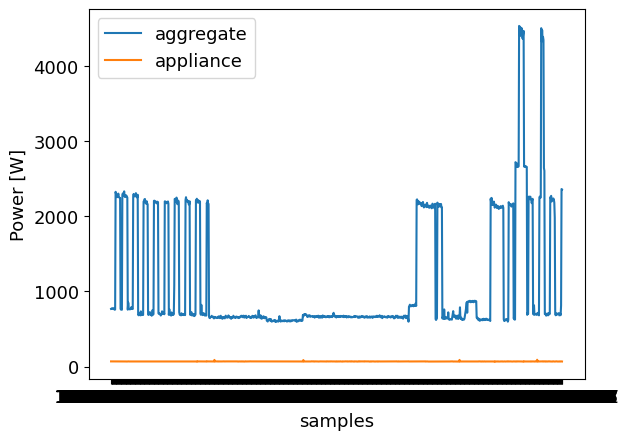

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
plt.rcParams.update({'font.size': 13})
import pandas as pd


def load(path, building, appliance, channel, nrows=None):
    # load csv
    file_name = path + 'house_' + str(building) + '/' + 'channel_' + str(channel) + '.dat'
    single_csv = pd.read_csv(file_name,
                             sep=' ',
                             #header=0,
                             names=['time', appliance],
                             dtype={'time': str, "appliance": int},
                             #parse_dates=['time'],
                             #date_parser=pd.to_datetime,
                             nrows=nrows,
                             usecols=[0, 1],
                             engine='python'
                             )
    return single_csv


appliance_name = 'television'  # 'kettle', 'microwave', 'fridge', 'television'
path = 'dataset/ukdale/'



# Change house number from here
building = 5


file_name = path +\
            'house_' + str(building) + '/' +\
            'channel_' +\
            str(params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses']
                .index(building)]) +\
            '.dat'

# Number of sample to plot
chunksize = 10**3

agg_df = load(path,
              building,
              appliance_name,
              1,
              nrows=chunksize,
              )

df = load(path,
          building,
          appliance_name,
          params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses'].index(building)],
          nrows=chunksize,
          )


"""
df = pd.read_csv(file_name,
            nrows=chunksize,
            index_col=False,
            names=['aggregate', appliance_name],
            usecols=[1, 2],
            header=0
            )

df = pd.read_csv(file_name,
            nrows=chunksize,
            index_col=False,
            names=['aggregate', appliance_name],
            usecols=[1, 2],
            header=0
            )
"""

df['aggregate'] = agg_df[appliance_name]
del agg_df

fig = plt.figure(num='Figure {:}'.format(appliance_name))
ax1 = fig.add_subplot(111)

ax1.plot(df['time'], df['aggregate'])
ax1.plot(df['time'], df[appliance_name])
#ax1.plot(chunk['Unix'], chunk['Appliance2'])
#ax1.plot(chunk['Unix'], chunk['Appliance3'])
#ax1.plot(chunk['Unix'], chunk['Appliance4'])
#ax1.plot(chunk['Unix'], chunk['Appliance5'])
#ax1.plot(chunk['Unix'], chunk['Appliance6'])
#ax1.plot(chunk['Unix'], chunk['Appliance7'])
#ax1.plot(chunk['Unix'], chunk['Appliance8'])
#ax1.plot(chunk['Unix'], chunk['Appliance9'])
#ax1.plot(chunk['Unix'], chunk['Issues']*1000)

#ax1.plot(chunk['Aggregate'])  # light blue
#ax1.plot(chunk['Appliance1'])  # orange
#ax1.plot(chunk['Appliance2'])  # green
#ax1.plot(chunk['Appliance3'])  # red
#ax1.plot(chunk['Appliance4'])  # violette
#ax1.plot(chunk['Appliance8'])  # brown
#ax1.plot(chunk['Appliance6'])  # pink
#ax1.plot(chunk['Appliance7'])  # gray
#x1.plot(chunk['Appliance8'])  # darkyellow
#ax1.plot(chunk['Appliance9'])  # azure

#ax1.set_title('{:}'.format(file_name), fontsize=14, fontweight='bold',
                  # y=1.08
#                  )

ax1.set_ylabel('Power [W]')
ax1.set_xlabel('samples')
ax1.legend(['aggregate', 'appliance'])
#ax1.grid()

mng = plt.get_current_fig_manager()
if hasattr(mng, "window"):
    mng.resize(*mng.window.maxsize())
plt.show(fig)



Seq2point train and test

In [5]:
import numpy as np 
import pandas as pd 

# batch_size: the number of rows fed into the network at once.
# crop: the number of rows in the data set to be used in total.
# chunk_size: the number of lines to read from the file at once.

import numpy as np 
import pandas as pd 

class TrainSlidingWindowGenerator():
    """Fixed Yields features and targets for training a ConvNet.

    Parameters:
    __file_name (string): The path where the training dataset is located.
    __batch_size (int): The size of each batch from the dataset to be processed.
    __chunk_size (int): The size of each chunk of data to be processed.
    __shuffle (bool): Whether the dataset should be shuffled before being returned.
    __offset (int): Half window size for sequence-to-point
    __crop (int): The number of rows of the dataset to return.
    __skip_rows (int): The number of rows of a dataset to skip before reading data.
    __ram_threshold (int): The maximum amount of RAM to utilise at a time.
    total_size (int): The number of rows read from the dataset.
    """

    def __init__(self, 
                file_name, 
                chunk_size, 
                shuffle, 
                offset, 
                batch_size=500, 
                crop=500000,  # Increased from 10K to 500K
                skip_rows=0,  # Don't skip rows by default
                ram_threshold=5 * 10 ** 5):
        self.__file_name = file_name
        self.__batch_size = batch_size
        self.__chunk_size = chunk_size
        self.__shuffle = shuffle
        self.__offset = offset
        self.__crop = crop
        self.__skip_rows = skip_rows
        self.__ram_threshold = ram_threshold
        self.__total_size = 0
        self.__total_num_samples = crop

    @property
    def total_num_samples(self):
        return self.__total_num_samples
    
    @total_num_samples.setter
    def total_num_samples(self, value):
        self.__total_num_samples = value

    def check_if_chunking(self):
        """Count the number of rows in the dataset and determine whether this is larger than the chunking 
        threshold or not."""

        print("Importing training file...")
        chunks = pd.read_csv(self.__file_name, 
                            header=0, 
                            nrows=self.__crop, 
                            skiprows=self.__skip_rows, 
                            skip_blank_lines=True)
        print("Counting number of rows...")
        self.__total_size = len(chunks)
        del chunks
        print("Done.")

        print("The dataset contains ", self.__total_size, " rows")

        if (self.__total_size > self.__ram_threshold):
            print("There is too much data to load into memory, so it will be loaded in chunks.")
    
    def load_dataset(self):
        """Fixed version: Yields pairs of features and targets for neural network training.

        Yields:
        input_data (numpy.array): A 3D array of shape (batch_size, window_length, 1) 
        output_data (numpy.array): A 2D array of shape (batch_size, 1) containing target values
        """

        if self.__total_size == 0:
            self.check_if_chunking()

        # If the data can be loaded in one go
        if (self.__total_size <= self.__ram_threshold):
            print("Loading all data into memory...")
            
            # Load the CSV data
            data_array = np.array(pd.read_csv(self.__file_name, 
                                            nrows=self.__crop, 
                                            skiprows=self.__skip_rows, 
                                            header=0, 
                                            skip_blank_lines=True))
            
            # Separate inputs (aggregate power) and outputs (appliance power)
            inputs = data_array[:, 0]   # Aggregate power
            outputs = data_array[:, 1]  # Appliance power

            # Calculate valid sample range (need full windows)
            window_length = 2 * self.__offset + 1  # Total window length
            maximum_batch_size = len(inputs) - window_length + 1
            self.total_num_samples = maximum_batch_size
            
            if self.__batch_size < 0:
                self.__batch_size = maximum_batch_size

            print(f"Window length: {window_length}")
            print(f"Total samples available: {maximum_batch_size}")
            print(f"Batch size: {self.__batch_size}")

            # Create indices for sampling
            indices = np.arange(maximum_batch_size)
            if self.__shuffle:
                np.random.shuffle(indices)

            # Infinite generator loop
            while True:
                for start_index in range(0, maximum_batch_size, self.__batch_size):
                    end_index = min(start_index + self.__batch_size, maximum_batch_size)
                    batch_indices = indices[start_index:end_index]
                    
                    # Create input windows
                    input_data = np.array([
                        inputs[idx:idx + window_length] 
                        for idx in batch_indices
                    ])
                    
                    # Get corresponding output values (center of window)
                    output_data = np.array([
                        outputs[idx + self.__offset] 
                        for idx in batch_indices
                    ])
                    
                    # Reshape for CNN: (batch_size, window_length, 1)
                    input_data = input_data.reshape(-1, window_length, 1)
                    output_data = output_data.reshape(-1, 1)
                    
                    yield input_data, output_data
                    
                # Reshuffle for next epoch
                if self.__shuffle:
                    np.random.shuffle(indices)
                    
        else:
            # Handle chunked loading (for very large datasets)
            print("Loading data in chunks...")
            
            chunk_starts = np.arange(0, self.__total_size, self.__chunk_size)
            if self.__shuffle:
                np.random.shuffle(chunk_starts)

            for chunk_start in chunk_starts:
                # Load chunk
                chunk_size = min(self.__chunk_size, self.__total_size - chunk_start)
                data_array = np.array(pd.read_csv(
                    self.__file_name, 
                    skiprows=self.__skip_rows + chunk_start, 
                    header=0 if chunk_start == 0 else None,
                    nrows=chunk_size, 
                    skip_blank_lines=True
                ))
                
                inputs = data_array[:, 0]
                outputs = data_array[:, 1]

                window_length = 2 * self.__offset + 1
                maximum_batch_size = len(inputs) - window_length + 1
                
                if maximum_batch_size <= 0:
                    continue
                    
                indices = np.arange(maximum_batch_size)
                if self.__shuffle:
                    np.random.shuffle(indices)

                # Process this chunk
                for start_index in range(0, maximum_batch_size, self.__batch_size):
                    end_index = min(start_index + self.__batch_size, maximum_batch_size)
                    batch_indices = indices[start_index:end_index]
                    
                    input_data = np.array([
                        inputs[idx:idx + window_length] 
                        for idx in batch_indices
                    ])
                    
                    output_data = np.array([
                        outputs[idx + self.__offset] 
                        for idx in batch_indices
                    ])
                    
                    # Reshape for CNN
                    input_data = input_data.reshape(-1, window_length, 1)
                    output_data = output_data.reshape(-1, 1)
                    
                    yield input_data, output_data

# Test function to verify the generator works
  

                    
class TestSlidingWindowGenerator(object):
    """Yields features and targets for testing and validating a ConvNet.

    Parameters:
    __number_of_windows (int): The number of sliding windows to produce.
    __offset (int): The offset of the infered value from the sliding window.
    __inputs (numpy.ndarray): The available testing / validation features.
    __targets (numpy.ndarray): The target values corresponding to __inputs.
    __total_size (int): The total number of inputs.
    """

    def __init__(self, number_of_windows, inputs, targets, offset):
        self.__number_of_windows = number_of_windows
        self.__offset = offset
        self.__inputs = inputs
        self.__targets = targets
        self.total_size = len(inputs)

    def load_dataset(self):
        """Returns all features and targets for testing and validating a ConvNet.

        Returns:
        tuple: (input_data, target_data) - Complete arrays for testing
        """
        self.__inputs = self.__inputs.flatten()
        max_number_of_windows = self.__inputs.size - 2 * self.__offset

        if self.__number_of_windows < 0:
            self.__number_of_windows = max_number_of_windows

        # Collect all data instead of yielding
        all_input_data = []
        all_target_data = []
        
        indicies = np.arange(max_number_of_windows, dtype=int)
        for start_index in range(0, max_number_of_windows, self.__number_of_windows):
            splice = indicies[start_index : start_index + self.__number_of_windows]
            
            # Pre-filter indices to ensure both input and target are valid
            valid_input_data = []
            valid_target_indices = []
            
            for index in splice:
                # Check if we can create a complete input window
                window_end = index + 2 * self.__offset + 1
                target_idx = index + self.__offset
                
                # Ensure both input window and target index are within bounds
                if window_end <= self.__inputs.size and target_idx < len(self.__targets):
                    window = self.__inputs[index : window_end]
                    
                    # Double-check window has expected length (should be guaranteed now)
                    expected_length = 2 * self.__offset + 1
                    if len(window) == expected_length:
                        valid_input_data.append(window)
                        valid_target_indices.append(target_idx)
            
            # Only add batch if we have valid data
            if len(valid_input_data) > 0:
                input_data = np.array(valid_input_data)
                target_data = self.__targets[valid_target_indices].reshape(-1, 1)
                
                all_input_data.append(input_data)
                all_target_data.append(target_data)
        
        if not all_input_data:
            raise ValueError("No valid windows could be generated. Check your data and parameters.")
        
        # Concatenate all batches
        final_input_data = np.concatenate(all_input_data, axis=0)
        final_target_data = np.concatenate(all_target_data, axis=0)
        
        print(f"Generated {len(final_input_data)} windows with input shape {final_input_data.shape} and target shape {final_target_data.shape}")
        
        return final_input_data, final_target_data
    
    def get_test_input_data(self):
        """Returns the full sliding window input data, without targets (for inference)."""
        self.__inputs = self.__inputs.flatten()
        max_number_of_windows = self.__inputs.size - 2 * self.__offset

        if self.__number_of_windows < 0:
            self.__number_of_windows = max_number_of_windows

        indices = np.arange(max_number_of_windows, dtype=int)
        splice = indices[:self.__number_of_windows]

        input_data = np.array([
            self.__inputs[index : index + 2 * self.__offset + 1]
            for index in splice
        ])

        return input_data

    def generate_batches(self):
        """Generator function that yields batches for streaming data processing."""
        self.__inputs = self.__inputs.flatten()
        max_number_of_windows = self.__inputs.size - 2 * self.__offset

        if self.__number_of_windows < 0:
            self.__number_of_windows = max_number_of_windows

        indicies = np.arange(max_number_of_windows, dtype=int)
        for start_index in range(0, max_number_of_windows, self.__number_of_windows):
            splice = indicies[start_index : start_index + self.__number_of_windows]
            
            # Apply same filtering logic as load_dataset
            valid_input_data = []
            valid_target_indices = []
            
            for index in splice:
                window_end = index + 2 * self.__offset + 1
                target_idx = index + self.__offset
                
                if window_end <= self.__inputs.size and target_idx < len(self.__targets):
                    window = self.__inputs[index : window_end]
                    
                    expected_length = 2 * self.__offset + 1
                    if len(window) == expected_length:
                        valid_input_data.append(window)
                        valid_target_indices.append(target_idx)
            
            if len(valid_input_data) > 0:
                input_data = np.array(valid_input_data)
                target_data = self.__targets[valid_target_indices].reshape(-1, 1)
                yield input_data, target_data

Model Structure

In [10]:
import tensorflow as tf 
import os

def create_model(input_window_length):
    """
    Fixed seq2point model for NILM using Conv1D layers.
    
    Parameters:
    input_window_length (int): Length of input sequence (599 for NILM)
    
    Returns:
    model (tensorflow.keras.Model): The compiled seq2point model.
    """
    
    # Input layer - 1D time series
    input_layer = tf.keras.layers.Input(shape=(input_window_length, 1))
    
    # Conv1D layers for time series processing
    conv_layer_1 = tf.keras.layers.Conv1D(filters=30, kernel_size=10, 
                                         strides=1, padding="same", 
                                         activation="relu")(input_layer)
    
    conv_layer_2 = tf.keras.layers.Conv1D(filters=30, kernel_size=8, 
                                         strides=1, padding="same", 
                                         activation="relu")(conv_layer_1)
    
    conv_layer_3 = tf.keras.layers.Conv1D(filters=40, kernel_size=6, 
                                         strides=1, padding="same", 
                                         activation="relu")(conv_layer_2)
    
    conv_layer_4 = tf.keras.layers.Conv1D(filters=50, kernel_size=5, 
                                         strides=1, padding="same", 
                                         activation="relu")(conv_layer_3)
    
    conv_layer_5 = tf.keras.layers.Conv1D(filters=50, kernel_size=5, 
                                         strides=1, padding="same", 
                                         activation="relu")(conv_layer_4)
    
    # Add dropout for regularization
    dropout_1 = tf.keras.layers.Dropout(0.2)(conv_layer_5)
    
    # Flatten and dense layers
    flatten_layer = tf.keras.layers.Flatten()(dropout_1)
    dense_layer = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer)
    dropout_2 = tf.keras.layers.Dropout(0.2)(dense_layer)
    
    # Output layer for regression
    output_layer = tf.keras.layers.Dense(1, activation="linear")(dropout_2)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model


def save_model(model, network_type, algorithm, appliance, save_model_dir):

    """ Saves a model to a specified location. Models are named using a combination of their 
    target appliance, architecture, and pruning algorithm.

    Parameters:
    model (tensorflow.keras.Model): The Keras model to save.
    network_type (string): The architecture of the model ('', 'reduced', 'dropout', or 'reduced_dropout').
    algorithm (string): The pruning algorithm applied to the model.
    appliance (string): The appliance the model was trained with.

    """
    
    #model_path = "saved_models/" + appliance + "_" + algorithm + "_" + network_type + "_model.h5"
    model_path = save_model_dir

    if not os.path.exists (model_path):
        open((model_path), 'a').close()

    model.save(model_path)

def load_model(model, network_type, algorithm, appliance, saved_model_dir):

    """ Loads a model from a specified location.

    Parameters:
    model (tensorflow.keras.Model): The Keas model to which the loaded weights will be applied to.
    network_type (string): The architecture of the model ('', 'reduced', 'dropout', or 'reduced_dropout').
    algorithm (string): The pruning algorithm applied to the model.
    appliance (string): The appliance the model was trained with.

    """

    #model_name = "saved_models/" + appliance + "_" + algorithm + "_" + network_type + "_model.h5"
    model_name = saved_model_dir
    print("PATH NAME: ", model_name)

    model = tf.keras.models.load_model(model_name)
    num_of_weights = model.count_params()
    print("Loaded model with ", str(num_of_weights), " weights")
    return model

In [6]:
def remove_space(string):
    return string.replace(" ","")

Train main

In [11]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt


#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
class Trainer():

    """ Used to train a seq2point model with or without pruning applied Supports 
    various alternative architectures. 
    
    Parameters:
    __appliance (string): The target appliance.
    __network_type (string): The architecture of the model.
    __batch_size (int): The number of rows per testing batch.
    __window_size (int): The size of eaech sliding window
    __window_offset (int): The offset of the inferred value from the sliding window.
    __max_chunk_size (int): The largest possible number of row per chunk.
    __validation_frequency (int): The number of epochs between model validation.
    __training_directory (string): The directory of the model's training file.
    __validation_directory (string): The directory of the model's validation file.
    __training_chunker (TrainSlidingWindowGenerator): A sliding window provider 
    that returns feature / target pairs. For training use only.
    __validation_chunker (TrainSlidingWindowGenerator): A sliding window provider 
    that returns feature / target pairs. For validation use only.
    
    """

    def __init__(self, appliance, batch_size, crop, network_type, 
                 training_directory, validation_directory, save_model_dir,
                 epochs=10, input_window_length=599, validation_frequency = 1,
                 patience=3, min_delta=1e-6, verbose=1):
        self.__appliance = appliance
        self.__algorithm = network_type
        self.__network_type = network_type
        self.__crop = crop
        self.__batch_size = batch_size
        self.__epochs = epochs
        self.__patience = patience
        self.__min_delta = min_delta
        self.__verbose = verbose
        self.__loss = "mse"
        self.__metrics = ["mse", "msle", "mae"]
        self.__learning_rate = 0.001
        self.__beta_1=0.9
        self.__beta_2=0.999
        self.__save_model_dir = save_model_dir

        self.__input_window_length = input_window_length
        self.__window_size = 2+self.__input_window_length
        self.__window_offset = int((0.5 * self.__window_size) - 1)
        self.__max_chunk_size = 5 * 10 ** 2
        self.__validation_frequency = validation_frequency
        self.__ram_threshold=5*10**5
        self.__skip_rows_train=0
        self.__validation_steps=100
        self.__skip_rows_val = 0

        # Directories of the training and validation files. Always has the structure 
        # ./dataset_management/refit/{appliance_name}/{appliance_name}_training_.csv for training or 
        # ./dataset_management/refit/{appliance_name}/{appliance_name}_validation_.csv
        self.__training_directory = training_directory
        self.__validation_directory = validation_directory

        self.__training_chunker = TrainSlidingWindowGenerator(file_name=self.__training_directory, 
                                        chunk_size=self.__max_chunk_size, 
                                        batch_size=self.__batch_size, 
                                        crop=self.__crop, shuffle=True,
                                        skip_rows=self.__skip_rows_train, 
                                        offset=self.__window_offset, 
                                        ram_threshold=self.__ram_threshold)
        self.__validation_chunker = TrainSlidingWindowGenerator(file_name=self.__validation_directory, 
                                            chunk_size=self.__max_chunk_size, 
                                            batch_size=self.__batch_size, 
                                            crop=self.__crop, 
                                            shuffle=True,
                                            skip_rows=self.__skip_rows_val, 
                                            offset=self.__window_offset, 
                                            ram_threshold=self.__ram_threshold)

    def train_model(self):

        """ Trains an energy disaggregation model using a user-selected pruning algorithm (default is no pruning). 
        Plots and saves the resulting model. """

        # Calculate the optimum steps per epoch.
        # self.__training_chunker.check_if_chunking()
        #steps_per_training_epoch = np.round(int(self.__training_chunker.total_size / self.__batch_size), decimals=0)
        steps_per_training_epoch = np.round(int(self.__training_chunker.total_num_samples / self.__batch_size), decimals=0)
        
        model = create_model(self.__input_window_length)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.__learning_rate, beta_1=self.__beta_1, beta_2=self.__beta_2), loss=self.__loss, metrics=self.__metrics) 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=self.__min_delta, patience=self.__patience, verbose=self.__verbose, mode="auto")

        ## can use checkpoint ###############################################
        # checkpoint_filepath = "checkpoint/housedata/refit/"+ self.__appliance + "/"
        # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #     filepath = checkpoint_filepath,
        #     monitor='val_loss',
        #     verbose=0,
        #     save_best_only=True,
        #     save_weights_only=False,
        #     mode='auto',
        #     save_freq='epoch')        
        #callbacks=[early_stopping, model_checkpoint_callback]
        ###################################################################

        callbacks=[early_stopping]
        
        training_history = self.default_train(model, callbacks, steps_per_training_epoch)

        training_history.history["val_loss"] = np.repeat(training_history.history["val_loss"], self.__validation_frequency)

        model.summary()
        save_model(model, self.__network_type, self.__algorithm, 
                   self.__appliance, self.__save_model_dir)
        
        print(f"\n=== MODEL SIZE INFO ===")
        print(f"Total parameters: {model.count_params():,}")
        print(f"Expected model size: ~{model.count_params() * 4 / (1024*1024):.1f} MB")
        print(f"Input shape: {model.input_shape}")
        print(f"Output shape: {model.output_shape}")

        self.plot_training_results(training_history)

    def default_train(self, model, callbacks, steps_per_training_epoch):

        """ The default training method the neural network will use. No pruning occurs.

        Parameters:
        model (tensorflow.keras.Model): The seq2point model being trained.
        early_stopping (tensorflow.keras.callbacks.EarlyStopping): An early stopping callback to 
        prevent overfitting.
        steps_per_training_epoch (int): The number of training steps to occur per epoch.

        Returns:
        training_history (numpy.ndarray): The error metrics and loss values that were calculated 
        at the end of each training epoch.

        """
        # ########### this is retired ##############################
        # training_history = model.fit_generator(self.__training_chunker.load_dataset(),
        #     steps_per_epoch=steps_per_training_epoch,
        #     epochs=1,
        #     verbose=1,
        #     validation_data = self.__validation_chunker.load_dataset(),
        #     validation_steps=100,
        #     validation_freq=self.__validation_frequency,
        #     callbacks=[early_stopping])
        ############################################################

        training_history = model.fit(self.__training_chunker.load_dataset(),                            
                      steps_per_epoch=int(steps_per_training_epoch),
                      epochs=self.__epochs,
                      verbose=self.__verbose,
                      callbacks=callbacks,
                      validation_data=self.__validation_chunker.load_dataset(),
                      validation_freq=self.__validation_frequency,
                      validation_steps=self.__validation_steps)

        return training_history

    def plot_training_results(self, training_history):

        """ Plots and saves a graph of training loss against epoch.

        Parameters:
        training_history (numpy.ndarray): A timeseries of loss against epoch count.

        """

        plt.plot(training_history.history["loss"], label="MSE (Training Loss)")
        plt.plot(training_history.history["val_loss"], label="MSE (Validation Loss)")
        plt.title('Training History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        #file_name = "./" + self.__appliance + "/saved_models/" + self.__appliance + "_" + self.__pruning_algorithm + "_" + self.__network_type + "_training_results.png"
        #plt.savefig(fname=file_name)

Test main

In [17]:
import os
import logging
import numpy as np 
import keras
import pandas as pd
import tensorflow as tf 
import time
import matplotlib.pyplot as plt

class Tester():

    """ Used to test and evaluate a pre-trained seq2point model with or without pruning applied. 
    
    Parameters:
    __appliance (string): The target appliance.
    __algorithm (string): The (pruning) algorithm the model was trained with.
    __network_type (string): The architecture of the model.
    __crop (int): The maximum number of rows of data to evaluate the model with.
    __batch_size (int): The number of rows per testing batch.
    __window_size (int): The size of each sliding window
    __window_offset (int): The offset of the inferred value from the sliding window.
    __test_directory (string): The directory of the test file for the model.
    
    """

    def __init__(self, appliance, algorithm, crop, batch_size, network_type,
                 test_directory, saved_model_dir, log_file_dir,
                 input_window_length, mains_data=None, params_appliance=None):
        self.__appliance = appliance
        self.__algorithm = algorithm
        self.__network_type = network_type

        self.__crop = crop
        self.__batch_size = batch_size
        self._input_window_length = input_window_length
        self.__window_size = self._input_window_length + 2
        self.__window_offset = int(0.5 * self.__window_size - 1)
        self.__number_of_windows = 100

        self.__test_directory = test_directory
        self.__saved_model_dir = saved_model_dir

        self.__mains_data = mains_data or {"mean": 0, "std": 1}
        self.__params_appliance = params_appliance or {appliance: {"mean": 0, "std": 1}}
        
        if params_appliance:
            self.__params_appliance = params_appliance
        else:
            self.__params_appliance = {appliance: {"mean": 0, "std": 1}}

        self.__log_file = log_file_dir
        logging.basicConfig(filename=self.__log_file,level=logging.INFO)


    
    def test_model(self):

        # Tests a fully-trained model using a sliding window generator as an input. Measures inference time, gathers, and 
        #plots evaluationg metrics. 

        test_input, test_target = self.load_dataset(self.__test_directory)
        #below 2 lines were commented
        model = create_model(self._input_window_length)
        model = load_model(model, self.__network_type, self.__algorithm, 
                           self.__appliance, self.__saved_model_dir)


        #change made
        #model = load_model(self.__saved_model_dir)
        #model = tf.keras.models.load_model(self.__saved_model_dir)



        test_generator = TestSlidingWindowGenerator(number_of_windows=self.__number_of_windows, inputs=test_input, targets=test_target, offset=self.__window_offset) #targets=test_target, was part

        # Calculate the optimum steps per epoch.
        steps_per_test_epoch = np.round(int(test_generator.total_size / self.__batch_size), decimals=0)

        # Test the model.
        start_time = time.time()
        #changes made here
        testing_history = model.predict(x=test_generator.get_test_input_data(), steps=steps_per_test_epoch,  verbose=2) #.load_dataset was changed to get_test_input_data

        end_time = time.time()
        test_time = end_time - start_time

        evaluation_metrics = model.evaluate(x=test_generator.get_test_input_data(), steps=steps_per_test_epoch)

        # Calculate accuracy metrics
        accuracy_percentage = self.calculate_accuracy(testing_history, test_target)
        print(f"Model accuracy: {accuracy_percentage:.1f}%")

        self.log_results(model, test_time, evaluation_metrics, accuracy_percentage)
        # You must provide mains_data as a dictionary with "mean" and "std" keys
        mains_data = {
            "mean": 522,
            "std":  814        
        }
        self.plot_results(testing_history, test_input, test_target, mains_data)
    

    def calculate_accuracy(self, predictions, targets, threshold_percent=0.1):
        """
        Calculate simple percentage accuracy for the model's predictions.

        Parameters:
        predictions (numpy.array): The predicted values from the model.
        targets (numpy.array): The true target values.
        threshold_percent (float): Threshold for accuracy calculation (default 0.1 = 10%)

        Returns:
        float: Simple percentage accuracy (e.g., 75.0 for 75% accuracy)
        """
        # Flatten arrays if they're not 1D
        if predictions.ndim > 1:
            predictions = predictions.flatten()
        if targets.ndim > 1:
            targets = targets.flatten()

        # Ensure arrays have the same length
        min_length = min(len(predictions), len(targets))
        predictions = predictions[:min_length]
        targets = targets[:min_length]

        # Calculate accuracy within threshold
        targets_safe = np.where(targets == 0, 1e-8, targets)
        percentage_error = np.abs(predictions - targets) / targets_safe * 100
        accuracy_within_threshold = np.mean(percentage_error <= (threshold_percent * 100)) * 100

        return accuracy_within_threshold
    

    def load_dataset(self, directory):
        """Loads the testing dataset from the location specified by file_name.

        Parameters:
        directory (string): The location at which the dataset is stored, concatenated with the file name.

        Returns:
        test_input (numpy.array): The first n (crop) features of the test dataset.
        test_target (numpy.array): The first n (crop) targets of the test dataset.

        """

        data_frame = pd.read_csv(directory, nrows=self.__crop, skiprows=0, header=0)
        test_input = np.round(np.array(data_frame.iloc[:, 0], float), 6)
        test_target = np.round(np.array(data_frame.iloc[self.__window_offset: -self.__window_offset, 1], float), 6)
        
        del data_frame
        return test_input, test_target

    def log_results(self, model, test_time, evaluation_metrics, accuracy_percentage=None):

        """Logs the inference time, MAE and MSE of an evaluated model.

        Parameters:
        model (tf.keras.Model): The evaluated model.
        test_time (float): The time taken by the model to infer all required values.
        evaluation_metrics (list): The MSE, MAE, and various compression ratios of the model.
        accuracy_percentage (float): Dictionary containing accuracy metrics.

        """

        inference_log = "Inference Time: " + str(test_time)
        logging.info(inference_log)

        #changes made here
        #metric_string = "MSE: ", str(evaluation_metrics[0]), " MAE: ", str(evaluation_metrics[3])
        if len(evaluation_metrics) >= 2:
            metric_string = f"MSE: {evaluation_metrics[0]} MAE: {evaluation_metrics[1]}"
        else:
            metric_string = f"Loss: {evaluation_metrics[0]}"
        logging.info(metric_string)

        # Log accuracy metrics if provided
        if accuracy_percentage is not None:
            logging.info(f"Model Accuracy: {accuracy_percentage:.1f}%")
            logging.info("========================")

        self.count_pruned_weights(model)  

    def count_pruned_weights(self, model):

        """ Counts the total number of weights, pruned weights, and weights in convolutional 
        layers. Calculates the sparsity ratio of different layer types and logs these values.

        Parameters:
        model (tf.keras.Model): The evaluated model.

        """
        num_total_zeros = 0
        num_dense_zeros = 0
        num_dense_weights = 0
        num_conv_zeros = 0
        num_conv_weights = 0
        for layer in model.layers:
             weights = layer.get_weights()
             if weights:
                layer_weights = weights[0].flatten()

                if "conv" in layer.name:
                    num_conv_weights += np.size(layer_weights)
                    num_conv_zeros += np.count_nonzero(layer_weights==0)

                    num_total_zeros += np.size(layer_weights)
                else:
                    num_dense_weights += np.size(layer_weights)
                    num_dense_zeros += np.count_nonzero(layer_weights==0)

        conv_zeros_string = "CONV. ZEROS: " + str(num_conv_zeros)
        conv_weights_string = "CONV. WEIGHTS: " + str(num_conv_weights)
        conv_sparsity_ratio = "CONV. RATIO: " + str(num_conv_zeros / num_conv_weights)

        dense_weights_string = "DENSE WEIGHTS: " + str(num_dense_weights)
        dense_zeros_string = "DENSE ZEROS: " + str(num_dense_zeros)
        dense_sparsity_ratio = "DENSE RATIO: " + str(num_dense_zeros / num_dense_weights)

        total_zeros_string = "TOTAL ZEROS: " + str(num_total_zeros)
        total_weights_string = "TOTAL WEIGHTS: " + str(model.count_params())
        total_sparsity_ratio = "TOTAL RATIO: " + str(num_total_zeros / model.count_params())

        print("LOGGING PATH: ", self.__log_file)

        logging.info(conv_zeros_string)
        logging.info(conv_weights_string)
        logging.info(conv_sparsity_ratio)
        logging.info("")
        logging.info(dense_zeros_string)
        logging.info(dense_weights_string)
        logging.info(dense_sparsity_ratio)
        logging.info("")
        logging.info(total_zeros_string)
        logging.info(total_weights_string)
        logging.info(total_sparsity_ratio)




    def plot_results(self, testing_history, test_input, test_target, mains_data):

        """ Generates and saves a plot of the testing history of the model against the (actual) 
        aggregate energy values and the true appliance values.
        """
        
        if self.__params_appliance and self.__appliance in self.__params_appliance:
            appliance_params = self.__params_appliance[self.__appliance]
            testing_history_denorm = (testing_history * appliance_params["std"]) + appliance_params["mean"]
            test_target_denorm = (test_target * appliance_params["std"]) + appliance_params["mean"]
        else:
            testing_history_denorm = testing_history
            test_target_denorm = test_target
        
        # Denormalize aggregate data
        if mains_data:
            test_agg = (test_input.flatten() * mains_data["std"]) + mains_data["mean"]
            test_agg = test_agg[self.__window_offset: -self.__window_offset]
        else:
            test_agg = test_input[self.__window_offset: -self.__window_offset]

        # Ensure non-negative energy values
        testing_history_denorm = np.maximum(testing_history_denorm, 0)
        test_target_denorm = np.maximum(test_target_denorm, 0)
        test_agg = np.maximum(test_agg, 0)

        # Ensure all arrays have the same length
        min_length = min(len(test_agg), len(test_target_denorm), len(testing_history_denorm))
        test_agg = test_agg[:min_length]
        test_target_denorm = test_target_denorm[:min_length]
        testing_history_denorm = testing_history_denorm[:min_length]

        # Plot testing outcomes against ground truth
        plt.figure(figsize=(12, 6))
       # plt.plot(test_agg, label="Aggregate", alpha=0.7)
        plt.plot(test_target_denorm, label="Ground Truth", linewidth=2)
        plt.plot(testing_history_denorm, label="Predicted", linewidth=2)
        plt.title(f"{self.__appliance} {self.__network_type} ({self.__algorithm})")
        plt.ylabel("Power Value (Watts)")
        plt.xlabel("Testing Window")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Optionally save the figure
        # file_path = f"./{self.__appliance}/saved_models/{self.__appliance}_{self.__algorithm}_{self.__network_type}_test_figure.png"
        # plt.savefig(fname=file_path, dpi=300, bbox_inches='tight')

        plt.show()

Training Implementation

Importing training file...
Counting number of rows...
Done.
The dataset contains  500000  rows
Loading all data into memory...
Window length: 599
Total samples available: 499402
Batch size: 500
Epoch 1/20
1000/1000 [==============================] - ETA: 0s - loss: 0.0893 - mse: 0.0893 - msle: 0.0056 - mae: 0.1352Importing training file...
Counting number of rows...
Done.
The dataset contains  500000  rows
Loading all data into memory...
Window length: 599
Total samples available: 499402
Batch size: 500
1000/1000 [==============================] - 273s 251ms/step - loss: 0.0893 - mse: 0.0893 - msle: 0.0056 - mae: 0.1352 - val_loss: 0.0193 - val_mse: 0.0193 - val_msle: 0.0048 - val_mae: 0.0434
Epoch 2/20
1000/1000 [==============================] - 245s 245ms/step - loss: 0.0297 - mse: 0.0297 - msle: 0.0056 - mae: 0.0935 - val_loss: 0.0178 - val_mse: 0.0178 - val_msle: 0.0046 - val_mae: 0.0281
Epoch 3/20
1000/1000 [==============================] - 246s 246ms/step - loss: 0.0264 - mse: 

INFO:tensorflow:Assets written to: saved_models/ukdale_models/kettle-R\assets


INFO:tensorflow:Assets written to: saved_models/ukdale_models/kettle-R\assets



=== MODEL SIZE INFO ===
Total parameters: 30,708,249
Expected model size: ~117.1 MB
Input shape: (None, 599, 1)
Output shape: (None, 1)


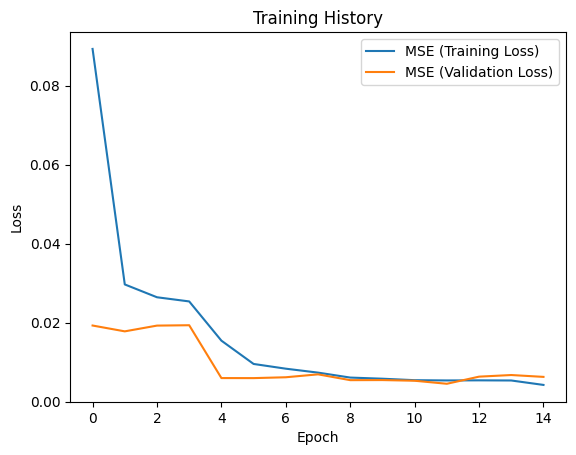

In [13]:
# Create Trainer instance

#test_directory = "refit/microwave/microwave_test_on_train_H10.csv"
#log_file_dir = "refit/microwave/microwave_test_on_train_H10.log"
training_directory="ukdale_seq2point/kettle/kettle_training_.csv"
validation_directory="Ukdale_seq2point/kettle/kettle_validation_.csv"
save_model_dir="saved_models/ukdale_models/kettle-R"


trainer = Trainer(
    appliance= args.appliance_name,
    batch_size=args.batch_size,
    crop=args.crop,
    network_type=args.network_type,
    training_directory = training_directory,
    validation_directory = validation_directory,
    save_model_dir=save_model_dir,
    epochs=args.epochs,
    input_window_length=args.input_window_length,
    validation_frequency=args.validation_frequency,
    patience=3,
    min_delta= 1e-6,
    #verbose=1
)

# Train the model
trainer.train_model()


In [ ]:
test_directory = "refit/microwave/microwave_test_on_train_H10.csv"
log_file_dir = "refit/microwave/microwave_test_on_train_H10.log"
training_directory="refit/microwave/microwave_training_.csv"
validation_directory="refit/microwave/microwave_validation_H17.csv"
save_model_dir="saved_models/ukdale_models/"

In [ ]:
tf.keras.backend.clear_session()
test_directory="ukdale_seq2point/microwave/microwave_test_.csv",
saved_model_dir="saved_models/ukdale_models/microwave",
log_file_dir="logs/microwave.log",

PATH NAME:  saved_models/ukdale_models/kettle-R
Loaded model with  30708249  weights


312/312 - 1s - 566ms/epoch - 2ms/step
 90/312 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - mse: 0.0000e+00 - msle: 0.0000e+00 - mae: 0.0000e+00WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 312 batches). You may need to use the repeat() function when building your dataset.


312/312 [==============================] - 1s 890us/step - loss: 0.0000e+00 - mse: 0.0000e+00 - msle: 0.0000e+00 - mae: 0.0000e+00
Model accuracy: 100.0%
LOGGING PATH:  logs/kettle.log


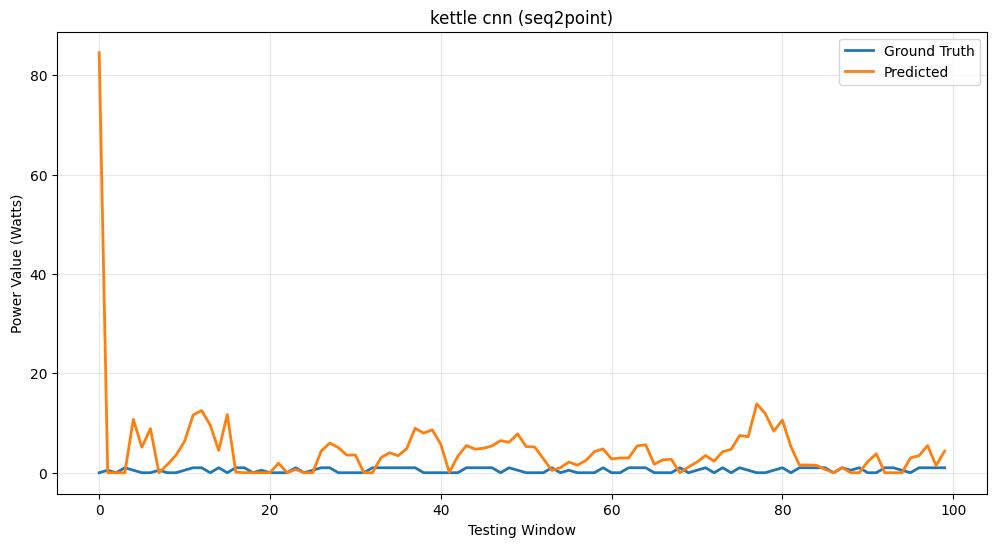

In [20]:

tester = Tester(
    appliance="kettle",
    algorithm="seq2point",
    crop=10000,
    batch_size=32,
    network_type="cnn",
    test_directory="ukdale_seq2point/kettle/kettle_test_uk-dale_H2.csv",
    saved_model_dir="saved_models/ukdale_models/kettle-R",
    log_file_dir="logs/kettle.log",
    input_window_length=599,
    mains_data={"mean": 522.3, "std": 814.7},  # Your actual aggregate data stats
    params_appliance={
        "kettle": {"mean": 700, "std": 1000}  # Your actual microwave stats
    }
)

tester.test_model()